In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

In [17]:
df = pd.read_csv('MobileDataSet.csv')

In [18]:
df = df[['brand', 'base_color', 'processor', 'screen_size', 'ROM', 'RAM', 'display_size', 'num_rear_camera', 'num_front_camera', 'battery_capacity', 'sales_price', 'sales']]
encoder = LabelEncoder()
df['brand'] = encoder.fit_transform(df['brand'])
df['base_color'] = encoder.fit_transform(df['base_color'])
df['processor'] = encoder.fit_transform(df['processor'])
df['screen_size'] = encoder.fit_transform(df['screen_size'])

In [19]:
X = df.drop(['sales_price'], axis=1)
y = df['sales_price']

In [20]:
X.head()

,brand,base_color,processor,screen_size,ROM,RAM,display_size,num_rear_camera,num_front_camera,battery_capacity,sales
0,0,0,5,4,64,2,4.7,1,1,1800,127.52
1,0,8,0,2,64,4,5.4,2,1,2815,1.39
2,0,8,5,4,64,2,4.7,1,1,1800,127.52
3,0,6,6,1,64,3,6.1,1,1,2942,23.07
4,0,8,0,1,128,4,6.1,2,1,2815,5.15


In [21]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [23]:
X_train.shape

(275, 11)

In [24]:
y_train = y_train.to_numpy().reshape(-1)

In [25]:
y_train.shape

(275,)

In [26]:
K = keras.backend


class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="relu")
])

In [29]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-3))
expon_lr = ExponentialLearningRate(factor=1.005)

In [30]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_val, y_val),
                    callbacks=[expon_lr])

9/9 [==============================] - 0s 19ms/step - loss: 1180281344.0000 - val_loss: 834551424.0000


Text(0, 0.5, 'Loss')

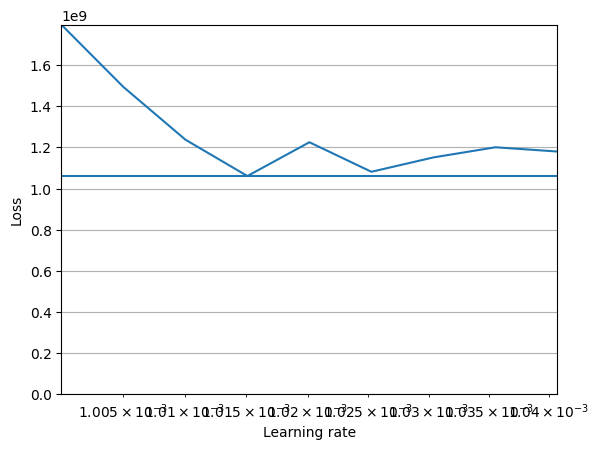

In [31]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [32]:
run_index = 1
run_logdir = os.path.join(os.curdir, "phones_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\phones_logs\\run_001'

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [34]:
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="relu")
])

In [68]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=5e-3))
expon_lr = ExponentialLearningRate(factor=1.015)

In [69]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("best_phones_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
9/9 [==============================] - 1s 57ms/step - loss: 1234228224.0000 - val_loss: 940014144.0000
Epoch 2/100
9/9 [==============================] - 0s 19ms/step - loss: 1234228224.0000 - val_loss: 940014144.0000
Epoch 3/100
9/9 [==============================] - 0s 22ms/step - loss: 1234228224.0000 - val_loss: 940014144.0000
Epoch 4/100
9/9 [==============================] - 0s 20ms/step - loss: 1234228224.0000 - val_loss: 940014144.0000
Epoch 5/100
9/9 [==============================] - 0s 13ms/step - loss: 1234228352.0000 - val_loss: 940014144.0000
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 1234228224.0000 - val_loss: 940014144.0000
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 1234228224.0000 - val_loss: 940014144.0000
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 1234228352.0000 - val_loss: 940014144.0000
Epoch 9/100
9/9 [==============================] - 0s 14ms/step - loss: 12342283

In [70]:
model = keras.models.load_model("best_phones_model.h5")  # rollback to best model
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 0s/step - loss: 1052454976.0000


1052454976.0

In [71]:
%reload_ext tensorboard

In [73]:
%tensorboard --logdir=./phones_logs --port=6009

Launching TensorBoard...